<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Frequency-response-of-a-closed-loop-system" data-toc-modified-id="Frequency-response-of-a-closed-loop-system-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Frequency response of a closed loop system</a></span><ul class="toc-item"><li><span><a href="#Controller-Validation:-PI-Velocity-Controller" data-toc-modified-id="Controller-Validation:-PI-Velocity-Controller-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><em>Controller Validation:</em> PI Velocity Controller</a></span></li><li><span><a href="#Creating-a-Sinusoidal-Input-to-your-closed-loop-control-system" data-toc-modified-id="Creating-a-Sinusoidal-Input-to-your-closed-loop-control-system-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Creating a Sinusoidal Input to your closed loop control system</a></span></li><li><span><a href="#Collect-Frequency-Response-Data" data-toc-modified-id="Collect-Frequency-Response-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Collect Frequency Response Data</a></span></li></ul></li><li><span><a href="#Digital-Control" data-toc-modified-id="Digital-Control-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Digital Control</a></span><ul class="toc-item"><li><span><a href="#PI-Velocity-Control" data-toc-modified-id="PI-Velocity-Control-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>PI Velocity Control</a></span></li></ul></li></ul></div>


## Frequency response of a closed loop system

While it is possible to sketch a Bode diagram for a system with a known transfer function, it is often useful to establish the frequency response of a system experimentally in order to either confirm its behavior matches your expectations, or to determine its transfer function in cases where a step response test is either not practical or would not yield enough information to fully explore or characterize a system's behavior.  To practice obtaining frequency response data experimentally, you will examine the steady state sinusoidal response of a system under closed loop control.  For this experiment you will use the PI controller for angular velocity that you designed and implemented in Lab 6 to control the benchtop motor-shaft-load system's angular velocity.  However, in addition to giving the system a step input to verify its behavior under closed-loop control, you will provide it a sinusoidal input.


### *Controller Validation:* PI Velocity Controller
Using the **MOTOR-SHAFT-LOAD** configuration and the plant you developed and used in Lab 7, design a PI controller (like the one you used in Lab 6) to achieve closed loop behavior with a settling time of 1.5 to 2 times faster than the open loop plant behavior, with a damping ratio $\zeta = 0.5$.

Perform all of the required calculations in the code block below. Include in your code:
* A plot of your plant model response along with the actual response as evidence of the validation of your **plant model.**
* Calculations for your selection of relevant zeros or gains
* A root locus plot that shows your target eigenvalue location and that the designed root locus passes throught that point
* **Output** that displays your zero and gain $K$.
* **Output** that displays your calculated controller gains $k_p$, $k_i$, and $k_{sum}$.
* Plot an actual step response and compare it to the predicted behavior on the same graph as a validation of your **controller.**


Transfer function 'P' from input 'u1' to output ...

        66.64  
 y1:  ---------
      s + 5.952

Continuous-time model.


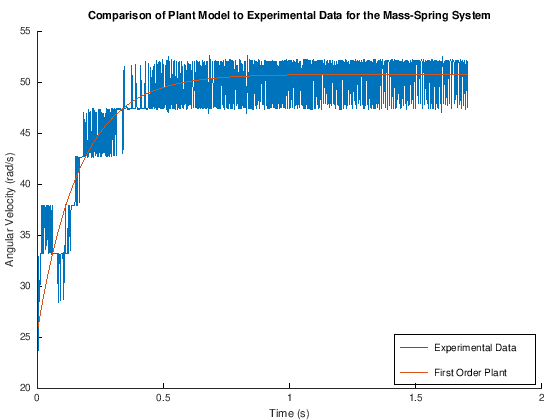

In [23]:
% loading data...
data_load = load('StepResponse_Weighted8.txt');
time_load = data_load(:,1)*10^-6; % time (s)
Vs_load = data_load(:,3); % voltages (V)
V0_load = Vs_load(1); % initial voltage (V)
startIndex_load = find(Vs_load>V0_load,1,'first'); % finding index where votlage step occurs
tstart_load = time_load(startIndex_load); % time where voltage step occurs
Vin_load = Vs_load(startIndex_load); % magnitude of input voltage after step (V)
omega_load = data_load(:,4); % angular speed (rad/s)
omega0_load = mean(omega_load(1:20)); % initial angular speed (rad/s)
omegass_load = mean(omega_load(end-20:end)); % steady state angular speed after voltage step (rad/s)
omega_trimmed = omega_load(startIndex_load:end); % trimmed angular speeds to only include after the voltage step
time_trimmed = time_load(startIndex_load:end)-tstart_load; % trimmed time to only include after the voltage step

% finding time constant (tau)
omegatau_load = (0.632*(omegass_load - omega0_load))+omega0_load; 
tau_load = time_load(find(omega_load<omegatau_load,1,'last'))-tstart_load; 
a = 1/tau_load;
A = ((omegass_load-omega0_load)*a)/(Vin_load-V0_load);

% plotting model against experimental data...
s = tf('s');
P = A/(s+a) % first order piece of third order system
[ysim_load1,tsim_load1]=step(P,time_trimmed);
ymodel_load1 = ((Vin_load-V0_load)*ysim_load1)+omega0_load;

figure
hold on;
plot(time_load(startIndex_load:end)-tstart_load,omega_load(startIndex_load:end))
plot(tsim_load1,ymodel_load1)
title('Comparison of Plant Model to Experimental Data for the Mass-Spring System')
xlabel('Time (s)')
ylabel('Angular Velocity (rad/s)')
legend('Experimental Data','First Order Plant','location','southeast')
hold off;

In [24]:
% finding open loop settling time...
[ysim,tsim] = step(P,5);
yss = ysim(end);
ts_open = tsim(find((((yss-ysim)/yss)*100)<=0.02,1,'first')); 

% defining desired eigenvalue...
zetad = 0.5;
ts_closed = ts_open/2;
wnd = 4/(ts_closed*zetad);
sd1 = -(zetad*wnd) + wnd*sqrt(1-zetad^2)*1j;
sd2 = -(zetad*wnd) - wnd*sqrt(1-zetad^2)*1j;

% calculating zero angle through angle deficiency...
ang_p1 = atan2d(wnd*sqrt(1-zetad^2),-zetad*wnd); % angle from pole at origin to target eigenvalue
ang_p2 = atan2d(wnd*sqrt(1-zetad^2),-zetad*wnd+a); % angle from pole at a to target eigenvalue
ang_z = -180+ang_p1+ang_p2; % angle from zeroto target eigenvalue
d = (wnd*sqrt(1-zetad^2))/(tand(ang_z));
z = zetad*wnd + d % zero

% determining gains...
GH = ((s+z)/s)*P
mag_GH_at_sd = abs((66.64*sd1+1608)/(sd1^2+5.952*sd1));
K = 1/(mag_GH_at_sd)
Ksum = 1
Kp = K/Ksum
Ki = Kp*z

z =  24.134

Transfer function 'GH' from input 'u1' to output ...

      66.64 s + 1608
 y1:  --------------
      s^2 + 5.952 s 

Continuous-time model.
K =  0.070758
Ksum =  1
Kp =  0.070758
Ki =  1.7077


                                                                               
                                       Root Locus of GH                        
                                                                               
                   |     &     &     &     &     &     &     &     &    &      
                20 |-+&&&&&&&&&&&&&&&&&&&&&&&&&&&&&+-----------$$$$$$-----+&   
                   |     &     &     &     &     & |###?###lo$$s    $$    |    
                15 |-+&&&&&&&&&&&&&&&&&&&&&&&&&&&&&|   B   open loop poles|&   
                   |     &     &     &     &     & +---F---zeros------$$--+    
                10 |-+&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&$&&&&&&&&&&$&&&&   
                   |     &     &     &     &     &     &   $ &     &   $&      
                 5 |-+&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&$&&&&&&&&&&&$&&&&   
                 0 |**#####################################$$$$$$F*****BB***   
                   |     &     &     &  

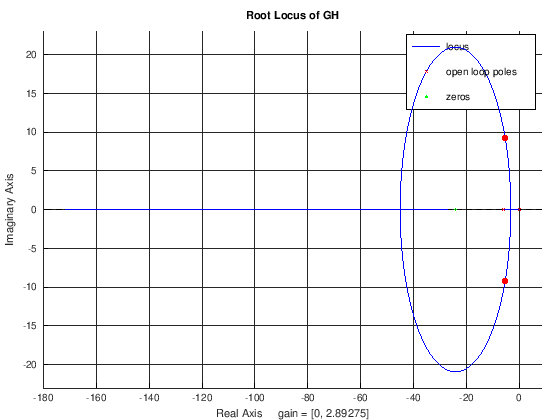

In [25]:
% plotting root locus...
figure()
hold on;
rlocus(GH)
plot(real(sd1),imag(sd1),'r.','MarkerSize',15)
plot(real(sd2),imag(sd2),'r.','MarkerSize',15)
hold off;


Transfer function 'GCL' from input 'u1' to output ...

         4.715 s^3 + 141.9 s^2 + 677.3 s   
 y1:  -------------------------------------
      s^4 + 16.62 s^3 + 177.3 s^2 + 677.3 s

Continuous-time model.


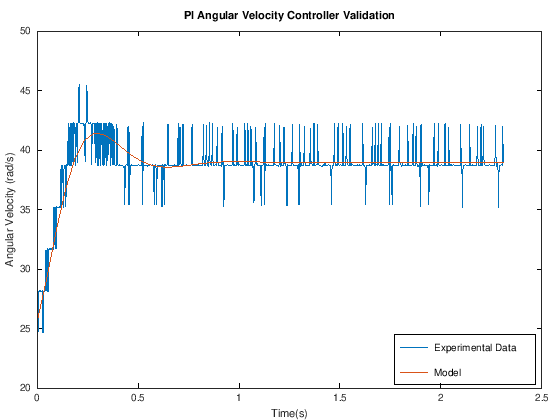

In [26]:
% plotting model to actual step response...
validdata = load('ControllerValidation2.txt');
time_valid = validdata(:,1)*1E-6;
desiredSpeed = validdata(:,2);
actualSpeed = validdata(:,3);
motorCount = validdata(:,4);
inputVoltage = validdata(:,5);
desiredSpeed0 = desiredSpeed(1);
startIndex = find(desiredSpeed>desiredSpeed0,1,'first');
startTime = time_valid(startIndex);
timetrimmed = time_valid(startIndex:end)-startTime;
desiredSpeedss = desiredSpeed(startIndex);
stepMag = desiredSpeedss - desiredSpeed0;

GCL = (K*GH)/(1+K*GH)
[y1,t1] = step(GCL,timetrimmed(end));
ymodel1 = (stepMag*y1)+desiredSpeed0;

figure()
plot(timetrimmed,actualSpeed(startIndex:end))
hold on;
plot(t1,ymodel1)
xlabel('Time(s)')
ylabel('Angular Velocity (rad/s)')
title('PI Angular Velocity Controller Validation')
legend('Experimental Data','Model','location','southeast')

### Creating a Sinusoidal Input to your closed loop control system

To date, you have applied a step input to the system using the use buttons.  However, with a few modifications the Arduino code can generate a sinusoidal input with adjustable amplitude and frequency.  

<font color='blue'>Make a copy of your PI controller code and implement the following modifications.</font>

<font size = 4> **WITHIN void setup** </font>
```C++
startTime = millis();
```

<font size = 4> **WITHIN void loop** </font>
```C++
elapsedTime = (millis()-startTime)/1000.0;
f = 1.0; //Hz.
    
//The code below replaces the existing code that calculates your desired velocity "r"
//Use one of the potentiometers to adjust the "desiredVelocityAmplitude" to be between 0-300 rad/s
r = desiredVelocityAmplitude*sin(f*2*PI*elapsedTime)+shift; //set "shift" so the sine wave output is always positive;
```
<font size = 4> **Ensure you declare any new variables appropriately** </font>


### Collect Frequency Response Data

* Set the amplitude and frequency to produce a complete sine wave at 1 Hz. 
* Output the desired velocity and the actual velocity to the ***serial plotter**** and observe the behavior.  If the desired velocity is is not entirely sinusoidal, adjust the amplitude.
* Ensure the output velocity is always positive and never reaches 0 rad/s once the system reaches steady state by adjusting the value of "shift".  *If you are not sure why you want to do this... ask!* 
* By observing the behavior of the output for a range of frequencies using the serial plotter, determine the lower and upper frequency limit outside of which the behavior of the output is "uninteresting". 
* Using ```logspace()``` select a set of frequencies throughout the range of "interesting" behavior you identified.
* Capture the input and output velocity amplitude to perform the fequency analysis in Octave/Matlab.
* ***Manually*** generate a mangitude ratio Bode plot from this initial data.  
* Continue to record/plot data at different frequencies until the behavior across the entire range is smoothly represented and easily identifiable.    
* Estimate the natural frequency of the closed loop system from the Bode plot.  If sufficient data has not been recorded to make a reasonable estimate, ***add data where necessary***.

*In the code cell below construct the Bode plot of your experimental data.  On your plot, identify the measured and theoretically predicted closed loop natural frequency.*

The frequency range in which "interesting" results were produced was from 0.5 Hz to 50 Hz. Thus, tests from 0.5 to 50 Hz with an appropriate amount of testing in between were conducted. The following MATLAB script shows the code used to plot the input and output angular speed on the same plot for each of the tests. The magnitude ratio was determined using the interactive plot and using the data cursor to pick points to calculate the amplitude of the input and output sine waves. The image below the MATLAB script shows a screen shot of the input and output angular speeds (for a frequency of 1 Hz) plotted on the same figure with points used to calculate amplitude displayed. 

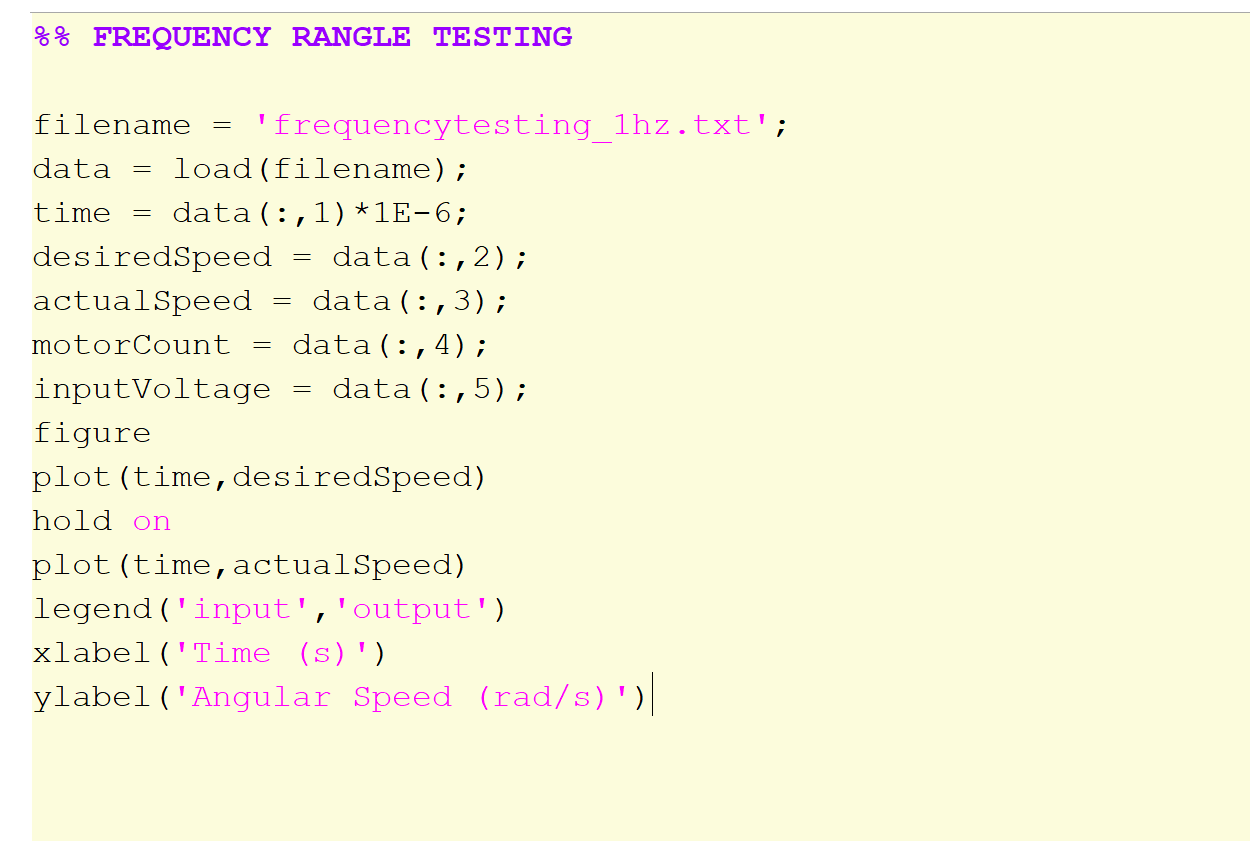

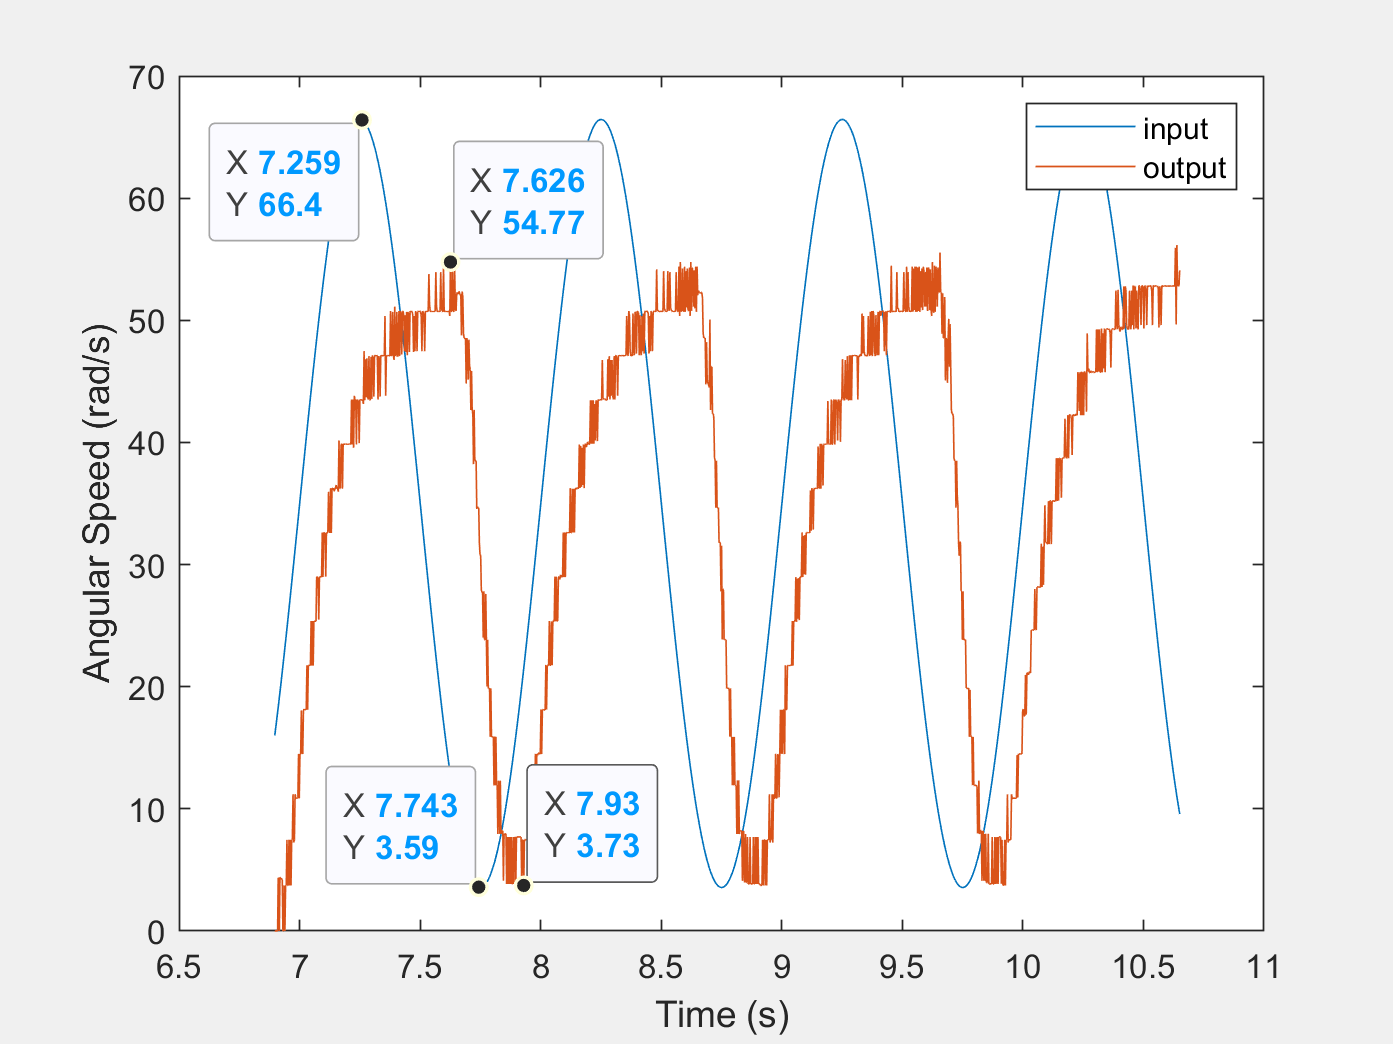

Using this specific plot, the input signal amplitude was calculated:

$|U| = \frac{66.4 \frac{rad}{s} - 3.59 \frac{rad}{s}}{2} = 31.41 \frac{rad}{s}$

The output signal amplitude was calculated to be:

$|Y| = \frac{54.77 \frac{rad}{s} - 3.73 \frac{rad}{s}}{2} = 25.52 \frac{rad}{s}$

Thus, the magnitude ratio is:

$MR = |\frac{Y}{U}| = \frac{25.52\frac{rad}{s}}{31.41\frac{rad}{s}} = 0.812$

Converting to decibles:

$MR_{dB} = 20\log_{10}{MR} = 20\log{10}{0.812} = -1.80 dB$

The same steps were repeated for all experiments with varying frequencies.

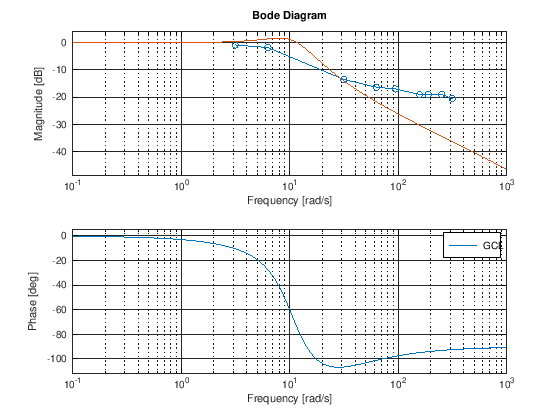

In [27]:
frequency = [0.5,1,5,10,15,25,30,40,50]*2*pi;
MR_dB = [-0.845,-1.80,-13.52,-16.38,-17.02,-19.05,-19.05,-19.05,-20.5];
figure()
subplot(2,1,1);
semilogx(frequency,MR_dB,'-o')
xlabel('Frequency [rad/s]')
ylabel('Magnitude [dB]')
title('Bode Magnitude Plot')
xlim([0.1 1000])
ylim([-27 2])
grid on
hold on
bode(GCL)

The natural frequency is estimated to be $\omega_n = 10 \frac{rad}{s}$ as that is where the low frequency and high frequency asymptotes meet on the bode plot.

**Include in the cell below a copy of your completed Arduino code. Double-click on this cell to see how to properly format your code as shown below:**

```c
//sample Arduino code
//properly formated for display
```

</font>

```javascript
#include <LiquidCrystal.h> //include LCD library

//initializing input and output pins
const int SSR_SWITCH = 23;
const int R1 = 25;
const int R2 = 27;
const int E_STOP = 4;
const int RWG_LED = 41;
const int RWR_LED = 39;
const int RFB_LED = 43;
const int RFR_LED = 45;
const int MOTOR1_PWM = 46;
const int MOTOR1_DIR = 48;
const int RELAY = 37;
const int P1 = A0;
const int P2 = A1;
const int BUT1 = 29;
int encoderChAPin = 2;   //Channel A pin for the encoder
int encoderChBPin = 3;   //Channel B pin for the encoder

// Pin numbers for LDC display
int lcd_rs_pin = 14;
int lcd_en_pin = 15;
int lcd_db4_pin = 16;
int lcd_db5_pin = 17;
int lcd_db6_pin = 18;
int lcd_db7_pin = 19;

//initializing states
bool SAFE = false;
bool FAULT = true;
bool READY = false;
bool WARNING = false;
bool RUNNING = false;

// initializing transitions
bool safeToReady = false;
bool readyToWarning = false;
bool warningLatch = false;
bool warningToRunning = false;
bool warningToReady = false;
bool safeToFault = false;
bool readyToFault = false;
bool warningToFault = false;
bool runningToFault = false;
bool faultToSafe = false;
bool readyToSafe = false;
bool warningToSafe = false;
bool runningToSafe = false;
bool safeLatch = false;
bool faultLatch = false;
bool readyLatch = false;
bool runningLatch = false;

// initializing miscellaneous variables
bool TMR1 = false;
bool SWITCH_OLD = true;
int ledState = LOW;
unsigned long previousMillis = 0;
const long interval = 250;
float desiredSpeed;
float inputVoltage;
float Kp = 0.070758;
float Ksum = 1;
float Ki = 1.7077;
volatile long encoderCountShared;
float motorPosition;
float pastPosition;
float motorSpeed;
unsigned long pastTime = 0;
float elapsedTime = 0;
float POT1_amp = 0;
float POT2_speed = 0;
float motor_count = 0;
float integralOfError;
float integralOfError_OLD;
float delta_t;
float desiredVelocityAmplitude;
float r;
float shift = 35; // for a desired velocity amplitude of ~30
float phi;
unsigned long startTime;
float f;

LiquidCrystal LCD(lcd_rs_pin, lcd_en_pin, lcd_db4_pin, lcd_db5_pin, lcd_db6_pin, lcd_db7_pin);

void setup() {
  LCD.begin(8, 2); // initialize LCD
  Serial.begin(115200);
  pinMode(SSR_SWITCH, INPUT);
  pinMode(R1, INPUT_PULLUP);
  pinMode(R2, INPUT_PULLUP);
  pinMode(E_STOP, INPUT_PULLUP);
  pinMode(RWG_LED, OUTPUT);
  pinMode(RWR_LED, OUTPUT);
  pinMode(RFB_LED, OUTPUT);
  pinMode(RFR_LED, OUTPUT);
  pinMode(RELAY, OUTPUT);
  pinMode(P1, INPUT);
  pinMode(P2, INPUT);
  pinMode(BUT1, INPUT_PULLUP);

  //encoder
  attachInterrupt(digitalPinToInterrupt(encoderChAPin), EncoderChA, CHANGE);
  attachInterrupt(digitalPinToInterrupt(encoderChBPin), EncoderChB, CHANGE);

  startTime = millis();
}

void loop() {
  noInterrupts();  //stop the interrupt system so the value doesn't change mid interrupt
  long encoderCount = encoderCountShared; //save the count value to a local variable
  interrupts();    //restart the interrupt system
  unsigned long currentMillis = millis(); //defining current time
  unsigned long currentTime = micros();
  elapsedTime = (millis()-startTime)/1000.0;
  f = 0.25; //Hz.

  // BLOCK 1: Process Inputs
  //----------------------------------------
  int SWITCH = digitalRead(SSR_SWITCH);
  int RUN1 = !digitalRead(R1); //negating so that this variable is 1 when pressed
  int RUN2 = !digitalRead(R2); //negating so that this variable is 1 when pressed
  int ESTOP = !digitalRead(E_STOP); //negating so that this variable is 1 when pressed
  int BTN1 = !digitalRead(BUT1); //negating so that this variable is 1 when pressed
  int POT1 = analogRead(P1);
  int POT2 = analogRead(P2);

  //call timer
  TMR1 = Timer(RUN1 && RUN2, 2000);

  // BLOCK 2: State Transition Logic
  //----------------------------------------
  safeToReady = SAFE && !SWITCH;
  readyToWarning = READY && RUN1 && RUN2;
  warningLatch = WARNING && !TMR1 && RUN1 && RUN2 && !SWITCH && !ESTOP;
  warningToRunning = WARNING && TMR1 && RUN1 && RUN2;
  warningToReady = WARNING && !TMR1 && !RUN1 || WARNING && !TMR1 && !RUN2;
  safeToFault = SAFE && ESTOP;
  readyToFault = READY && ESTOP;
  warningToFault = WARNING && ESTOP;
  runningToFault = RUNNING && ESTOP;
  faultToSafe = FAULT && !ESTOP && SWITCH && !SWITCH_OLD;
  readyToSafe = READY && SWITCH && !ESTOP;
  warningToSafe = WARNING && SWITCH && !ESTOP;
  runningToSafe = RUNNING && SWITCH && !ESTOP;
  safeLatch = SAFE && SWITCH && !ESTOP;
  faultLatch = FAULT && ESTOP || FAULT && !SWITCH || FAULT && SWITCH_OLD;
  readyLatch = READY && !RUN1 && !ESTOP && !SWITCH || READY && !RUN2 && !ESTOP && !SWITCH;
  runningLatch = RUNNING && !ESTOP && !SWITCH;

  // BLOCK 3: Update States
  //----------------------------------------
  SAFE = faultToSafe || readyToSafe || warningToSafe || runningToSafe || safeLatch;
  FAULT = safeToFault || readyToFault || warningToFault || runningToFault || faultLatch;
  READY = safeToReady || warningToReady || readyLatch;
  WARNING = readyToWarning || warningLatch;
  RUNNING = warningToRunning || runningLatch;

  // BLOCK 4: Set Outputs and Old Variables
  //----------------------------------------
  delta_t = (currentTime-pastTime)*1E-6;
  desiredVelocityAmplitude = POT1_amp;
  phi += 2*PI*f*delta_t;
  r = desiredVelocityAmplitude*sin(phi)+shift;
  
  if (SAFE == 1) {
    digitalWrite(RELAY, LOW);
    digitalWrite(MOTOR1_PWM, LOW);
    digitalWrite(MOTOR1_DIR, LOW);

    //READY/WARNING LED illuminated green
    digitalWrite(RFR_LED, LOW);
    digitalWrite(RWR_LED, LOW);
    digitalWrite(RFB_LED, LOW);
    digitalWrite(RWG_LED, HIGH);

    // POT values
    POT1_amp = POT1 * (300.0 / 1021.0);

    // printing to LCD
    LCD.clear();
    LCD.print("P1: ");
    LCD.print(POT1_amp);

  }

  if (FAULT == 1) {
    digitalWrite(RELAY, LOW);
    digitalWrite(MOTOR1_PWM, LOW);
    digitalWrite(MOTOR1_DIR, LOW);

    //RUN/FAULT LED flashing red and all other LEDs switched off
    if (currentMillis - previousMillis >= interval) {
      previousMillis = currentMillis;
      if (ledState == LOW) {
        ledState = HIGH;
      } else {
        ledState = LOW;
      }
    }

    digitalWrite(RWG_LED, LOW);
    digitalWrite(RWR_LED, LOW);
    digitalWrite(RFB_LED, LOW);
    digitalWrite(RFR_LED, ledState);

    // printing to LCD
    LCD.clear();
    LCD.print("FAULT");
  }

  if (READY == 1) {
    digitalWrite(RELAY, LOW);
    digitalWrite(MOTOR1_PWM, LOW);
    digitalWrite(MOTOR1_DIR, LOW);

    //READY/WARNING LED flashing green and all other LEDs switched off
    if (currentMillis - previousMillis >= interval) {
      previousMillis = currentMillis;
      if (ledState == LOW) {
        ledState = HIGH;
      } else {
        ledState = LOW;
      }
    }
    digitalWrite(RWR_LED, LOW);
    digitalWrite(RFB_LED, LOW);
    digitalWrite(RFR_LED, LOW);
    digitalWrite(RWG_LED, ledState);
  }

  if (WARNING == 1) {
    digitalWrite(RELAY, LOW);
    digitalWrite(MOTOR1_PWM, LOW);
    digitalWrite(MOTOR1_DIR, LOW);

    //READY/WARNING LED flashing red and all other LEDs switched off
    if (currentMillis - previousMillis >= interval) {
      previousMillis = currentMillis;
      if (ledState == LOW) {
        ledState = HIGH;
      } else {
        ledState = LOW;
      }
    }

    digitalWrite(RWG_LED, LOW);
    digitalWrite(RFR_LED, LOW);
    digitalWrite(RFB_LED, LOW);
    digitalWrite(RWR_LED, ledState);
  }

  if (RUNNING == 1) {
    //calculating actual motor speed
    motorPosition = encoderCount * (PI / 300);
    motorSpeed = (motorPosition - pastPosition) / (delta_t);
    float error = r - motorSpeed;
    integralOfError = integralOfError_OLD + error*delta_t;
    inputVoltage = Ksum*(Kp*error + Ki*integralOfError);
    inputVoltage = constrain(inputVoltage, 0.0, 5.0);
    motor_count = inputVoltage / 5 * 255;

    digitalWrite(RELAY, HIGH);
    analogWrite(MOTOR1_PWM, motor_count);
    digitalWrite(MOTOR1_DIR, LOW);

    //RUN/FAULT LED illuminated blue
    digitalWrite(RWG_LED, LOW);
    digitalWrite(RWR_LED, LOW);
    digitalWrite(RFR_LED, LOW);
    digitalWrite(RFB_LED, HIGH);

    //printing to Serial monitor...
    Serial.print(micros());
    Serial.print("\t");
    Serial.print(r);
    Serial.print("\t");
    Serial.print(motorSpeed);
    Serial.print("\t");
    Serial.print(motor_count);
    Serial.print("\t");
    Serial.print(inputVoltage);
    Serial.print("\t");
    Serial.println();
  }

  // setting "old" variables
  SWITCH_OLD = SWITCH;
  pastTime = currentTime;
  pastPosition = motorPosition;
  integralOfError_OLD = integralOfError;

}
```

## Digital Control

The closed loop controllers you have implemented this semester have all been digital controllers.  The Arduinos you are using are one example of a microcontroller which is a small computer that typically perform a single function.


Unlike a controller made from electronic amplifiers (like op-amps) that essentially respond continuously to changes in the system, microcontrollers respond at descrete times.  To date you have been implicitely assuming that the response of the microcontroller is modeled accurately by continuous-time math.  This lab will explore the limitations of that assumption.

### PI Velocity Control

Using the same PI controller from the first part of this lab, perform the following experiment.  Make sure to make a new copy of the file so the original is preserved.

**Capture the velocity response to a step input and compare it to your model's prediction in Matlab to confirm your controller is working properly and plot below.**  

Although you've done this above, you've made changes since.  This is an important step to confirm the entire system is set up and working as expected!


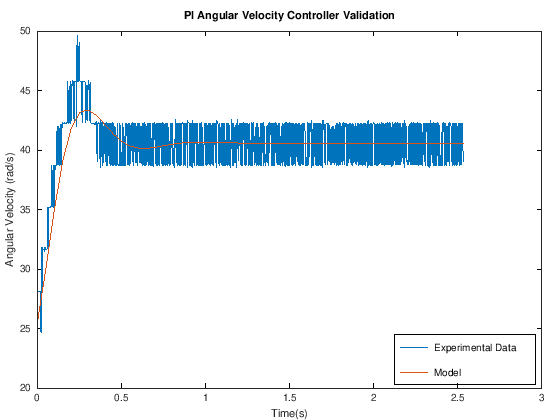

In [28]:
data = load('digitalcontrol_verification4.txt');
time = data(:,1)*1E-6;
desiredSpeed = data(:,2);
actualSpeed = data(:,3);
motorCount = data(:,4);
inputVoltage = data(:,5);
desiredSpeed0 = desiredSpeed(1);
startIndex = find(desiredSpeed>desiredSpeed0,1,'first');
startTime = time(startIndex);
timetrimmed = time(startIndex:end)-startTime;
desiredSpeedss = desiredSpeed(startIndex);
stepMag = desiredSpeedss - desiredSpeed0;

[y2,t2] = step(GCL,timetrimmed(end));
ymodel2 = (stepMag*y2)+desiredSpeed0;

figure()
plot(timetrimmed,actualSpeed(startIndex:end))
hold on;
plot(t2,ymodel2)
xlabel('Time(s)')
ylabel('Angular Velocity (rad/s)')
title('PI Angular Velocity Controller Validation')
legend('Experimental Data','Model','location','southeast')

* Add a [delay](https://www.arduino.cc/reference/en/language/functions/time/delay/) to your loop to increase the time between the samples the controller uses to update the control signal.  
* Increase the delay time until you find the ***minimum*** sampling time that causes the closed-loop system response to be unstable.

**Report the sampling time that causes the system to become unstable and describe the instability in the Markdown cell below.  Include a plot of the response in the code cell below**

The minimum delay time that caused the system to go unstable was 55 milliseconds, or 0.055 seconds. When this delay time was implemented, the FSM would oscillate between sending positive and negative count values to the motor. A visual depiction of this behavior can be seen in the below screenshot of the motor count over time plotted using the Serial plotter. 

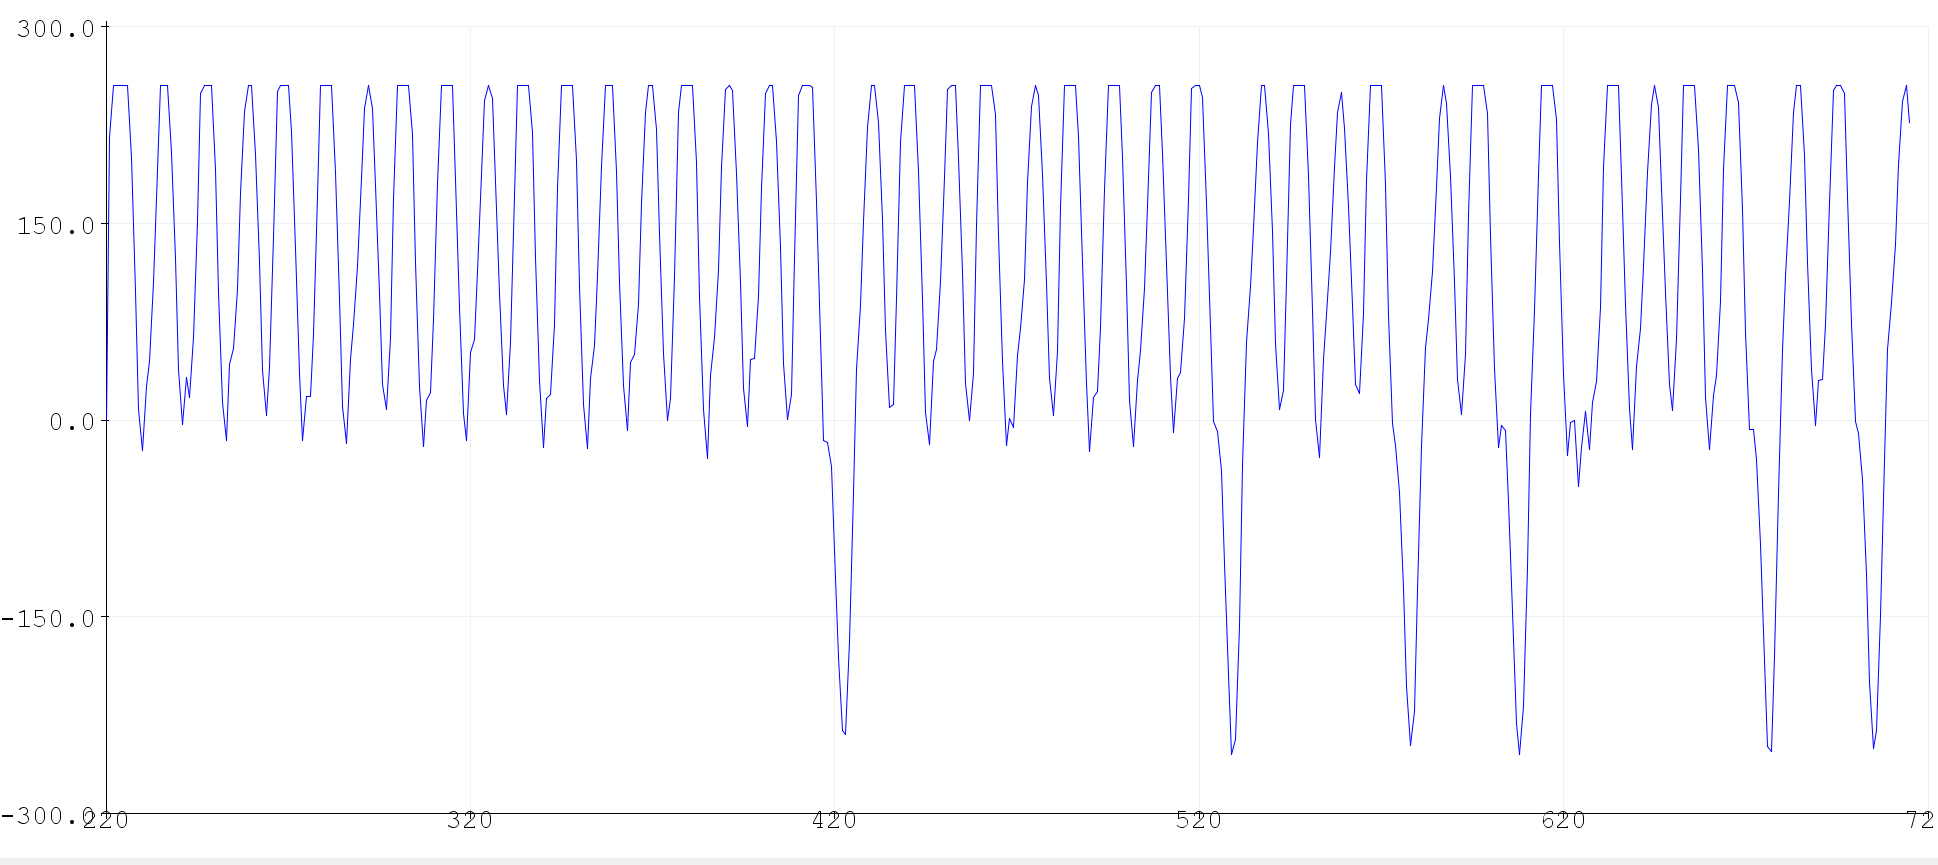

This plot shows the oscillation between sending 255 and -255 to the motor that is indicative of instability. 

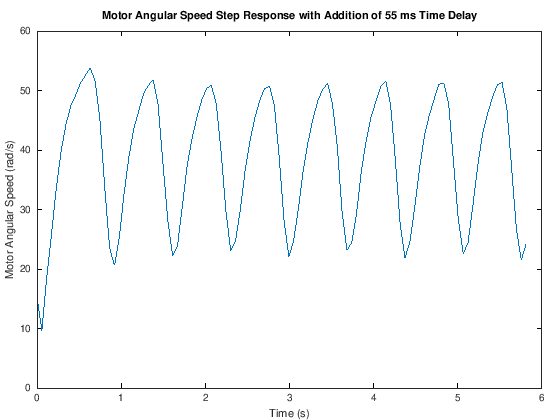

In [29]:
data_unstable = load('digitalcontrol_delay55.txt');
time_unstable = data_unstable(:,1)*1E-6;
desiredSpeed_unstable = data_unstable(:,2);
motorSpeed_unstable = data_unstable(:,3);
motorCount_unstable = data_unstable(:,4);
inputVoltage_unstable = data_unstable(:,5);

desiredSpeed0_unstable = desiredSpeed_unstable(1);
startIndex_unstable = find(desiredSpeed_unstable>desiredSpeed0_unstable,1,'first');
startTime_unstable = time_unstable(startIndex_unstable);
timetrimmed_unstable = time_unstable(startIndex_unstable:end)-startTime_unstable;

figure()
plot(timetrimmed_unstable,motorSpeed_unstable(startIndex_unstable:end))
xlabel('Time (s)')
ylabel('Motor Angular Speed (rad/s)')
title('Motor Angular Speed Step Response with Addition of 55 ms Time Delay')

* Record the system response to a step input (magnitude is your choice) at several sampling times *up to* the sampling time that causes the system to become unstable
* In the Matlab cell below, show and label the responses on a single plot.  
* Using the plot, explain how the system eigenvalues appear to be changing with increasing sample time in the Markdown cell below.

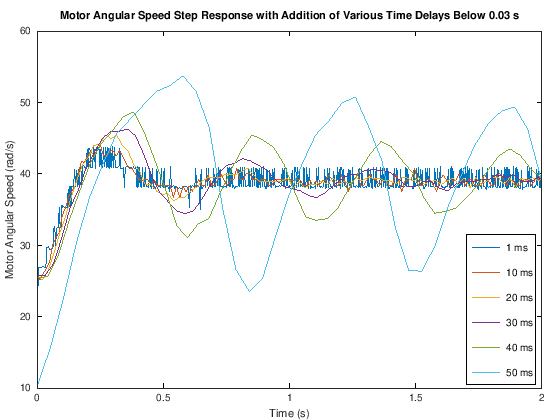

In [30]:
% time delay of 1 ms...
data_delay1 = load('digitalcontrol_delay1.txt');
time_delay1 = data_delay1(:,1)*1E-6;
desiredSpeed_delay1 = data_delay1(:,2);
motorSpeed_delay1 = data_delay1(:,3);
motorCount_delay1 = data_delay1(:,4);
inputVoltage_delay1 = data_delay1(:,5);

desiredSpeed0_delay1 = desiredSpeed_delay1(1);
startIndex_delay1 = find(desiredSpeed_delay1>desiredSpeed0_delay1,1,'first');
startTime_delay1 = time_delay1(startIndex_delay1);
timetrimmed_delay1 = time_delay1(startIndex_delay1:end)-startTime_delay1;

% time delay of 10 ms...
data_delay10 = load('digitalcontrol_delay10.txt');
time_delay10 = data_delay10(:,1)*1E-6;
desiredSpeed_delay10 = data_delay10(:,2);
motorSpeed_delay10 = data_delay10(:,3);
motorCount_delay10 = data_delay10(:,4);
inputVoltage_delay10 = data_delay10(:,5);

desiredSpeed0_delay10 = desiredSpeed_delay10(1);
startIndex_delay10 = find(desiredSpeed_delay10>desiredSpeed0_delay10,1,'first');
startTime_delay10 = time_delay10(startIndex_delay10);
timetrimmed_delay10 = time_delay10(startIndex_delay10:end)-startTime_delay10;

% time delay of 20 ms...
data_delay20 = load('digitalcontrol_delay20.txt');
time_delay20 = data_delay20(:,1)*1E-6;
desiredSpeed_delay20 = data_delay20(:,2);
motorSpeed_delay20 = data_delay20(:,3);
motorCount_delay20 = data_delay20(:,4);
inputVoltage_delay20 = data_delay20(:,5);

desiredSpeed0_delay20 = desiredSpeed_delay20(1);
startIndex_delay20 = find(desiredSpeed_delay20>desiredSpeed0_delay20,1,'first');
startTime_delay20 = time_delay20(startIndex_delay20);
timetrimmed_delay20 = time_delay20(startIndex_delay20:end)-startTime_delay20;

% time delay of 30 ms...
data_delay30 = load('digitalcontrol_delay30.txt');
time_delay30 = data_delay30(:,1)*1E-6;
desiredSpeed_delay30 = data_delay30(:,2);
motorSpeed_delay30 = data_delay30(:,3);
motorCount_delay30 = data_delay30(:,4);
inputVoltage_delay30 = data_delay30(:,5);

desiredSpeed0_delay30 = desiredSpeed_delay30(1);
startIndex_delay30 = find(desiredSpeed_delay30>desiredSpeed0_delay30,1,'first');
startTime_delay30 = time_delay30(startIndex_delay30);
timetrimmed_delay30 = time_delay30(startIndex_delay30:end)-startTime_delay30;

% time delay of 40 ms...
data_delay40 = load('digitalcontrol_delay40.txt');
time_delay40 = data_delay40(:,1)*1E-6;
desiredSpeed_delay40 = data_delay40(:,2);
motorSpeed_delay40 = data_delay40(:,3);
motorCount_delay40 = data_delay40(:,4);
inputVoltage_delay40 = data_delay40(:,5);

desiredSpeed0_delay40 = desiredSpeed_delay40(1);
startIndex_delay40 = find(desiredSpeed_delay40>desiredSpeed0_delay40,1,'first');
startTime_delay40 = time_delay40(startIndex_delay40);
timetrimmed_delay40 = time_delay40(startIndex_delay40:end)-startTime_delay40;

% time delay of 50 ms...
data_delay50 = load('digitalcontrol_delay50.txt');
time_delay50 = data_delay50(:,1)*1E-6;
desiredSpeed_delay50 = data_delay50(:,2);
motorSpeed_delay50 = data_delay50(:,3);
motorCount_delay50 = data_delay50(:,4);
inputVoltage_delay50 = data_delay50(:,5);

desiredSpeed0_delay50 = desiredSpeed_delay50(1);
startIndex_delay50 = find(desiredSpeed_delay50>desiredSpeed0_delay50,1,'first');
startTime_delay50 = time_delay50(startIndex_delay50);
timetrimmed_delay50 = time_delay50(startIndex_delay50:end)-startTime_delay50;

figure()
plot(timetrimmed_delay1,motorSpeed_delay1(startIndex_delay1:end))
hold on;
plot(timetrimmed_delay10,motorSpeed_delay10(startIndex_delay10:end))
plot(timetrimmed_delay20,motorSpeed_delay20(startIndex_delay20:end))
plot(timetrimmed_delay30,motorSpeed_delay30(startIndex_delay30:end))
plot(timetrimmed_delay40,motorSpeed_delay40(startIndex_delay40:end))
plot(timetrimmed_delay50,motorSpeed_delay50(startIndex_delay50:end))
xlabel('Time (s)')
ylabel('Motor Angular Speed (rad/s)')
title('Motor Angular Speed Step Response with Addition of Various Time Delays Below 0.03 s')
legend('1 ms','10 ms','20 ms','30 ms','40 ms','50 ms','location','southeast')
xlim([0 2]);
hold off;

It appears that with increasing time delay, the damping ratio is decreasing, thus creating larger oscillations. This can be clearly seen by the light blue line representing the data collected with a 50 millisecond time delay. The oscillations seen in the angular motor speed in response to a step input has much greater oscillations than the other datasets. More oscillations (smaller damping ratio) corresponds to the system's eigenvalues, specifically the imaginary piece increasing in magnitude. It can also correspond to the real piece of the system's eigenvalues moving more to the right (decreasing in magnitude). This would correlate to more oscillations as well as a slower decay, which is observed with increasing time delay.

* With the system at the minimum sample time required to cause instability, adjust the $k_{sum}$ value until the closed-loop response is stable again, and has a *similar* overshoot to the original design. 
* Plot this response and the continuous system response (no delay) on the same plot in the Matlab cell below.
* Explain the differences in the two responses in the Markdown cell below.

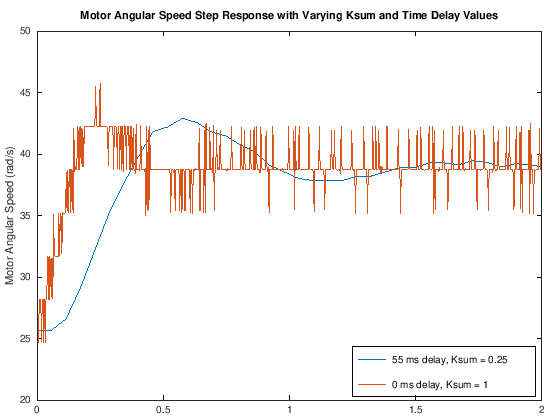

In [31]:
% delay of 55 ms w/ Ksum = 0.25
data_delay55 = load('digitalcontrol_delay55Ksum0.25.txt');
time_delay55 = data_delay55(:,1)*1E-6;
desiredSpeed_delay55 = data_delay55(:,2);
motorSpeed_delay55 = data_delay55(:,3);
motorCount_delay55 = data_delay55(:,4);
inputVoltage_delay55 = data_delay55(:,5);

desiredSpeed0_delay55 = desiredSpeed_delay55(1);
startIndex_delay55 = find(desiredSpeed_delay55>desiredSpeed0_delay55,1,'first');
startTime_delay55 = time_delay55(startIndex_delay55);
timetrimmed_delay55 = time_delay55(startIndex_delay55:end)-startTime_delay55;

% no time delay w/ Ksum = 1...
data_nodelay = load('digitalcontrol_delay0Ksum1.txt');
time_nodelay = data_nodelay(:,1)*1E-6;
desiredSpeed_nodelay = data_nodelay(:,2);
motorSpeed_nodelay = data_nodelay(:,3);
motorCount_nodelay = data_nodelay(:,4);
inputVoltage_nodelay = data_nodelay(:,5);

desiredSpeed0_nodelay = desiredSpeed_nodelay(1);
startIndex_nodelay = find(desiredSpeed_nodelay>desiredSpeed0_nodelay,1,'first');
startTime_nodelay = time_nodelay(startIndex_nodelay);
timetrimmed_nodelay = time_nodelay(startIndex_nodelay:end)-startTime_nodelay;

figure()
plot(timetrimmed_delay55,motorSpeed_delay55(startIndex_delay55:end))
hold on;
plot(timetrimmed_nodelay,motorSpeed_nodelay(startIndex_nodelay:end))
ylabel('Motor Angular Speed (rad/s)')
title('Motor Angular Speed Step Response with Varying Ksum and Time Delay Values')
legend('55 ms delay, Ksum = 0.25','0 ms delay, Ksum = 1','location','southeast')
xlim([0 2]);
hold off;

It was found that the $K_{sum}$ value that produced a stable and similar response to the continuous time response was $K_{sum} = 0.25$. The overshoot amount and steady state value between these two tests is relatively similar, where they differ is in rise time/settling time. Obviously, it would make sense for the dataset with the added time delay of 0.055 seconds to have a slower rise time as well as take longer to settle to a steady state value. In addition, there is also less noise in the non-continuous data, so the time delay also acts to smooth the collected data.